# SwitchableTokenizer Experiments (Training from Scratch)

This notebook runs the SwitchableTokenizer experiments with models trained from scratch instead of fine-tuning.
This allows evaluating how well the switchable tokenizer approach works with freshly initialized models.

## Overview of Experiments

1. **Experiment 1: Feasibility and Performance** - Compares the switchable tokenizer model with monolingual models
2. **Experiment 2: Comparison vs. Concatenated Vocab** - Compares the switchable tokenizer with a concatenated vocabulary
3. **Experiment 3: Multilingual Baseline** - Compares against a standard multilingual tokenizer
4. **Experiment 4: Context Sensitivity** - Analyzes how token probabilities shift based on language context

## Environment Setup

First, let's set up our environment by cloning the repository and installing dependencies.

In [1]:
# Clone the repository
!git clone https://github.com/hardesttype/switch-tokenizer.git
!cd switch-tokenizer

Cloning into 'switch-tokenizer'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 383 (delta 40), reused 54 (delta 19), pack-reused 306 (from 1)
Receiving objects: 100% (383/383), 255.12 KiB | 19.62 MiB/s, done.
Resolving deltas: 100% (258/258), done.


In [2]:
# Install required packages
# For colab you need only `datasets`
!pip install -q datasets huggingface_hub dotenv # torch transformers datasets tokenizers matplotlib seaborn tqdm numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda

In [3]:
# Check if running in Colab
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")

Running in Google Colab


In [9]:
# Set up Hugging Face token from Colab secrets
# Note: You need to add your HF token as a secret named 'hfToken' in Colab
# Go to: Colab menu -> Secrets -> Add new secret
if IN_COLAB:
    try:
        from google.colab import userdata
        hf_token = userdata.get('hfToken')
        if hf_token:
            print("✅ Hugging Face token loaded from Colab secrets")
            # Set the token as an environment variable
            import os
            os.environ["HF_TOKEN"] = hf_token
        else:
            print("❌ HF token not found in Colab secrets. Please add it via the Colab menu: Secrets -> Add new secret")
    except Exception as e:
        print(f"❌ Error accessing Colab secrets: {e}")
        print("Please add your Hugging Face token as a secret named 'hfToken' via the Colab menu: Secrets -> Add new secret")

✅ Hugging Face token loaded from Colab secrets


In [10]:
# Add the repository to the Python path
import sys
sys.path.append('/content/switch-tokenizer')

# Set environment variables
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Import common libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import set_seed

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Experiment 1: Feasibility and Performance

This experiment compares the performance of a model using the switchable tokenizer against individual monolingual models of similar size. It evaluates perplexity on held-out test data for each language.

We'll train the models from scratch instead of fine-tuning pre-trained models.

In [6]:
# Import necessary modules for Experiment 1
from experiments.experiment1_feasibility import main as experiment1_main
import argparse

# Set up argument parser for Experiment 1
def run_experiment1(data_limit=500, epochs=1, batch_size=4, seed=42,
                   en_dataset="wikimedia/wikipedia", en_subset="20231101.en",
                   ru_dataset="wikimedia/wikipedia", ru_subset="20231101.ru",
                   learning_rate=5e-5, max_seq_length=128,
                   base_model="gpt2-medium", output_dir="./experiment1_from_scratch_output",
                   first_shard_only=False, upload_to_hub=False, hub_repo_id=None):
    # Save original sys.argv
    orig_argv = sys.argv.copy()

    # Set new sys.argv with from_scratch flag
    sys.argv = ['experiment1_feasibility.py',
                '--from_scratch',
                f'--data_limit={data_limit}',
                f'--epochs={epochs}',
                f'--batch_size={batch_size}',
                f'--seed={seed}',
                f'--output_dir={output_dir}',
                f'--en_dataset={en_dataset}',
                f'--en_subset={en_subset}',
                f'--ru_dataset={ru_dataset}',
                f'--ru_subset={ru_subset}',
                f'--learning_rate={learning_rate}',
                f'--max_seq_length={max_seq_length}',
                f'--base_model={base_model}']

    # Add first_shard_only flag if enabled
    if first_shard_only:
        sys.argv.append('--first_shard_only')

    # Add Hugging Face upload options if enabled
    if upload_to_hub and hub_repo_id:
        sys.argv.append('--upload_to_hub')
        sys.argv.append(f'--hub_repo_id={hub_repo_id}')

    print(f"Running with command: {' '.join(sys.argv)}\n")

    # Run the experiment
    try:
        experiment1_main()
    finally:
        # Restore original sys.argv
        sys.argv = orig_argv

Running with command: experiment1_feasibility.py --from_scratch --data_limit=20000 --epochs=1 --batch_size=4 --seed=42 --output_dir=./experiment1_from_scratch_output --en_dataset=wikimedia/wikipedia --en_subset=20231101.en --ru_dataset=wikimedia/wikipedia --ru_subset=20231101.ru --learning_rate=0.0001 --max_seq_length=128 --base_model=gpt2-medium --first_shard_only --upload_to_hub --hub_repo_id=hardesttype/switch-tokenizer-exp-1

Starting Experiment 1...
Using device: cuda
Training from scratch: True
Sample sizes are balanced: the switchable model uses 10000 samples per language (total: 20000)
Each monolingual model uses 20000 samples of its language

Step 1: Training switchable tokenizer model...

=== Training Switchable Model ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.77M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

Using maximum tokenizer size: 50257 (EN: 50257, RU: 50257)
Preparing datasets...


README.md:   0%|          | 0.00/131k [00:00<?, ?B/s]

train-00000-of-00041.parquet:   0%|          | 0.00/420M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6407814 [00:00<?, ? examples/s]

train-00000-of-00021.parquet:   0%|          | 0.00/581M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1945063 [00:00<?, ? examples/s]

Creating model...


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Training model...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hottab250 (hottab250-foo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,8.460600
200,7.709400
300,7.593600
400,7.416200
500,7.277200
600,7.206800
700,7.116100
800,7.089400
900,6.957500
1000,6.901400



Step 2: Training monolingual models...

=== Training Monolingual Models ===

Training english monolingual model...


Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss
100,8.049900
200,7.373300
300,7.236100
400,7.077100
500,6.953600
600,6.822800
700,6.718100
800,6.656400
900,6.519100
1000,6.465700



Training russian monolingual model...


Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss
100,8.124200
200,7.499100
300,7.301000
400,7.117600
500,6.999200
600,6.863800
700,6.786400
800,6.621300
900,6.514000
1000,6.442900



Step 3: Evaluating models...

=== Evaluating Models ===
Setting up tokenizers...
Setting pad token for switchable tokenizer EN
Preparing shared evaluation samples...
  EN: 100 shared evaluation samples
  RU: 100 shared evaluation samples
Created switchable dataset for EN with 100 examples
Created monolingual dataset for EN with 100 examples
Created switchable dataset for RU with 100 examples
Created monolingual dataset for RU with 100 examples
Created combined dataset with 200 examples

Evaluating models on shared evaluation datasets:
Evaluating switchable model on shared EN dataset...


Calculating perplexity: 100%|██████████| 25/25 [00:03<00:00,  8.26it/s]


Switchable model EN perplexity on shared dataset: 431.15
Evaluating switchable model on shared RU dataset...


Calculating perplexity: 100%|██████████| 25/25 [00:03<00:00,  8.03it/s]


Switchable model RU perplexity on shared dataset: 1427.53
Evaluating switchable model on shared combined dataset...


Calculating perplexity: 100%|██████████| 50/50 [00:06<00:00,  8.21it/s]


Switchable model combined perplexity on shared dataset: 812.48
Evaluating english model on shared EN dataset...


Calculating perplexity: 100%|██████████| 25/25 [00:02<00:00,  8.67it/s]


English model perplexity on shared dataset: 203.75
Evaluating russian model on shared RU dataset...


Calculating perplexity: 100%|██████████| 25/25 [00:02<00:00,  8.65it/s]


Russian model perplexity on shared dataset: 717.35
Evaluating english model on RU dataset...


Calculating perplexity: 100%|██████████| 25/25 [00:02<00:00,  8.79it/s]


English model perplexity on RU dataset: 1042.55
Evaluating russian model on EN dataset...


Calculating perplexity: 100%|██████████| 25/25 [00:02<00:00,  8.64it/s]


Russian model perplexity on EN dataset: 3322.02
Calculating tokenization efficiency for switchable tokenizer on EN...
Switchable tokenizer EN tokens per word: 1.462
Calculating tokenization efficiency for english tokenizer...
English tokenizer tokens per word: 1.462
Calculating tokenization efficiency for switchable tokenizer on RU...
Switchable tokenizer RU tokens per word: 1.925
Calculating tokenization efficiency for russian tokenizer...
Russian tokenizer tokens per word: 1.925

Measuring cross-language tokenization efficiency...
Measuring EN tokenizer efficiency on RU text...
EN tokenizer on RU text: 7.995 tokens/word
Measuring RU tokenizer efficiency on EN text...
RU tokenizer on EN text: 1.769 tokens/word

Step 4: Plotting results...

=== Plotting Results ===
Perplexity plot saved to ./experiment1_from_scratch_output/perplexity_comparison.png
Tokenization efficiency values for plotting:
Switchable EN: 1.4619433198380567
Switchable RU: 1.9251626898047722
Monolingual EN: 1.46194331

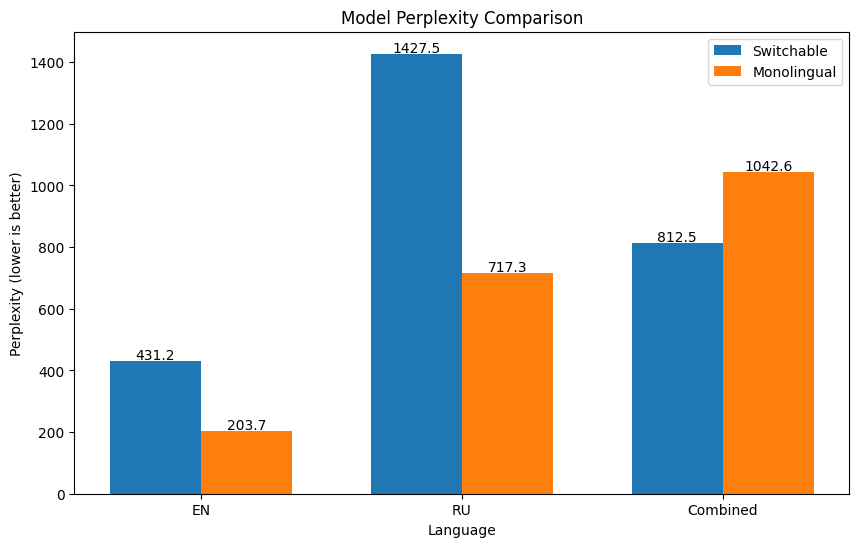

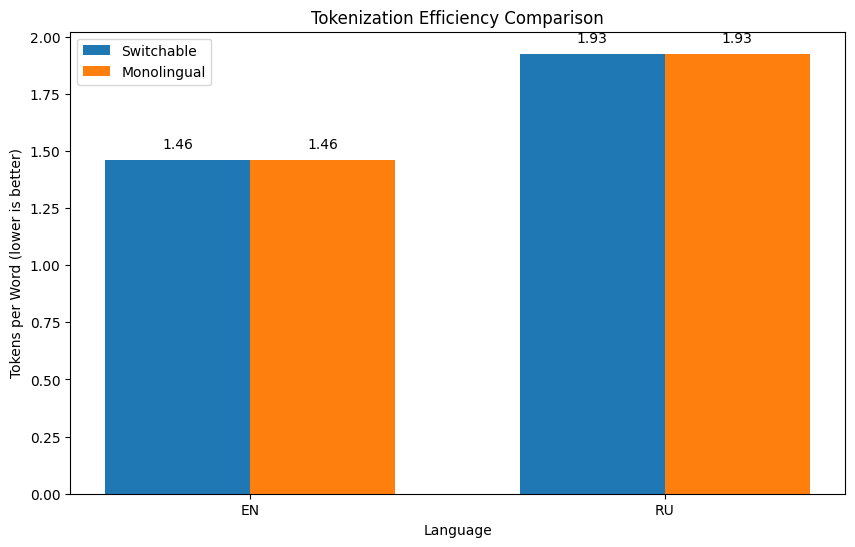

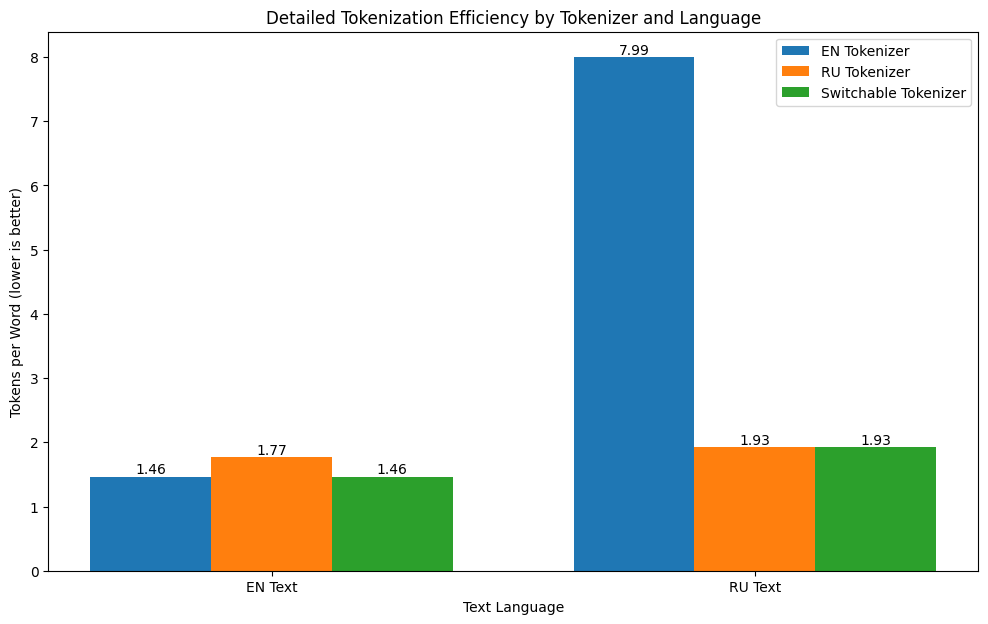

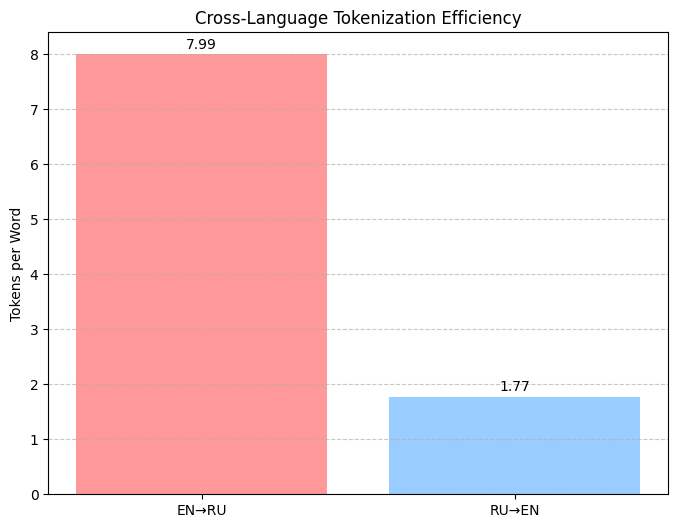


Plotting training losses...

=== Plotting Training Losses ===
Training losses plot saved to ./experiment1_from_scratch_output/training_losses.png


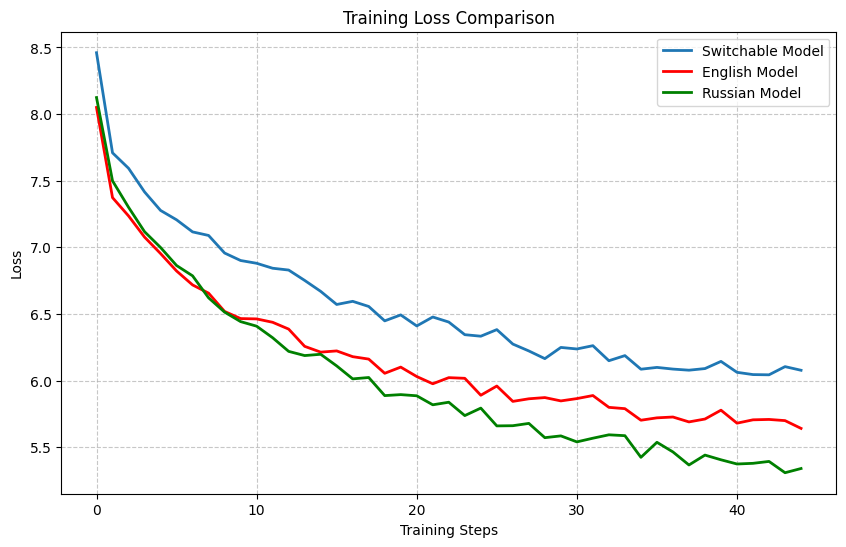


Results saved to ./experiment1_from_scratch_output/experiment1_results.txt

Uploading results to Hugging Face Hub...

=== Uploading Results to Hugging Face Hub ===
Error: No token found. Please set HF_TOKEN in .env file or environment variable
Create a .env file in the project root with: HF_TOKEN=your_token_here
Failed to upload results to Hugging Face Hub

Experiment 1 completed!


In [7]:
# Run Experiment 1 with small data for quicker execution in Colab
# Adjust parameters as needed based on your computational resources
run_experiment1(
    data_limit=20_000,           # Use smaller dataset for faster execution
    epochs=1,                 # Just one epoch for demonstration
    batch_size=4,             # Small batch size for memory efficiency
    en_dataset="wikimedia/wikipedia",  # Source dataset for English
    en_subset="20231101.en",   # English dataset subset
    ru_dataset="wikimedia/wikipedia",  # Source dataset for Russian
    ru_subset="20231101.ru",   # Russian dataset subset
    base_model="gpt2-medium",  # Use smaller model for faster training
    learning_rate=1e-4,       # Slightly higher learning rate for from-scratch training
    max_seq_length=128,        # Shorter sequences for faster training
    first_shard_only=True,    # Use only the first shard (train-00000-of-*) instead of counting examples
    # Uncomment and update these lines to enable HF Hub upload
    upload_to_hub=True,       # Enable uploading to Hugging Face Hub
    hub_repo_id="hardesttype/switch-tokenizer-exp-1"  # Replace with your repo ID
)